In [16]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import json

In [17]:
f = open('data.json')
data = json.load(f)
f.close()


In [18]:
Data = data[1]
P_b = Data["P_b"]
infstart = Data['infusion_start']
infend = Data["infusion_end"]
rec_len = infend-infstart

# These are values from the literature
params_means = [10.45, 0.33, 7.5]
params_stddevs = [2.03, 0.08, 1.5]
lower_bounds = [0.01, 0.01, -10.0]
upper_bounds = [50.0, 1.0, P_b]


In [19]:
def dyn_model(Rcsf, E, P_0):
    I_b = (Data["P_b"] - P_0) / Rcsf  # CSF formation rate

    infstart = Data['infusion_start']
    infend = Data["infusion_end"]
    I_inf = Data["I_inf"]

    Rn = Data["Rn"]  # Needle resistance (if one-needle only)
    dP = Data["P_b"] - P_0
    It = I_b + I_inf

    t = (np.arange(infstart, infend) - infstart) / 6.0
    Pm = It * dP / (I_b + (I_inf * np.exp(-E * It * t))) + \
    P_0 + (I_inf * Rn)

    return Pm

In [20]:
# Define PyMC model
with pm.Model() as model:

    # Priors
    E = pm.TruncatedNormal(
        'E', mu=params_means[1], sigma=params_stddevs[1], lower=lower_bounds[1], upper=upper_bounds[1])
    P0 = pm.TruncatedNormal(
        'P0', mu=params_means[2], sigma=params_stddevs[2], lower=lower_bounds[2], upper=upper_bounds[2])
    Rout = pm.TruncatedNormal(
        'Rout', mu=params_means[0], sigma=params_stddevs[0], lower=lower_bounds[0], upper=upper_bounds[0])

    # Soft Constraint (Potential) for a dependent variable
    # Ib = (Data["P_b"] - P0) / Rout
    # min_value = 0.01
    # max_value = 1.00
    # is_acceptable = ((min_value <= Ib) & (Ib <= max_value))
    # constraint_penalty = pm.math.switch(is_acceptable, 0.0, np.inf)
    # pm.Potential('constraint_penalty', -constraint_penalty)

    # Standard deviation for the likelihood
    sigma = pm.TruncatedNormal(
        'sigma', mu=0, sigma=1, lower=0, upper=np.inf)

    # Compute model predictions
    predicted = dyn_model(Rout, E, P0)

    # Likelihood (Gaussian)
    likelihood = pm.Normal('likelihood', mu=predicted, sigma=sigma,
                        observed=Data["pressure"][infstart:infend])

In [21]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample(5000)

# Generate predictions for each posterior sample
posterior_samples = idata.posterior
n_samples = len(posterior_samples.chain) * len(posterior_samples.draw)
predicted_curves = np.zeros((n_samples, rec_len))

for i, (Rout, E, P0) in enumerate(zip(posterior_samples.Rout.values.flatten(),
                                    posterior_samples.E.values.flatten(),
                                    posterior_samples.P0.values.flatten())):
    predicted_curves[i, :] = dyn_model(Rout, E, P0)

# Calculate mean and standard deviation of predictions
mean_prediction = np.mean(predicted_curves, axis=0)
std_prediction = np.std(predicted_curves, axis=0)

# Time points for plotting
time_points = np.arange(infstart, infend)

    # Plot actual data for comparison
icp_trace = Data["pressure"][infstart:infend]



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [E, P0, Rout, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.


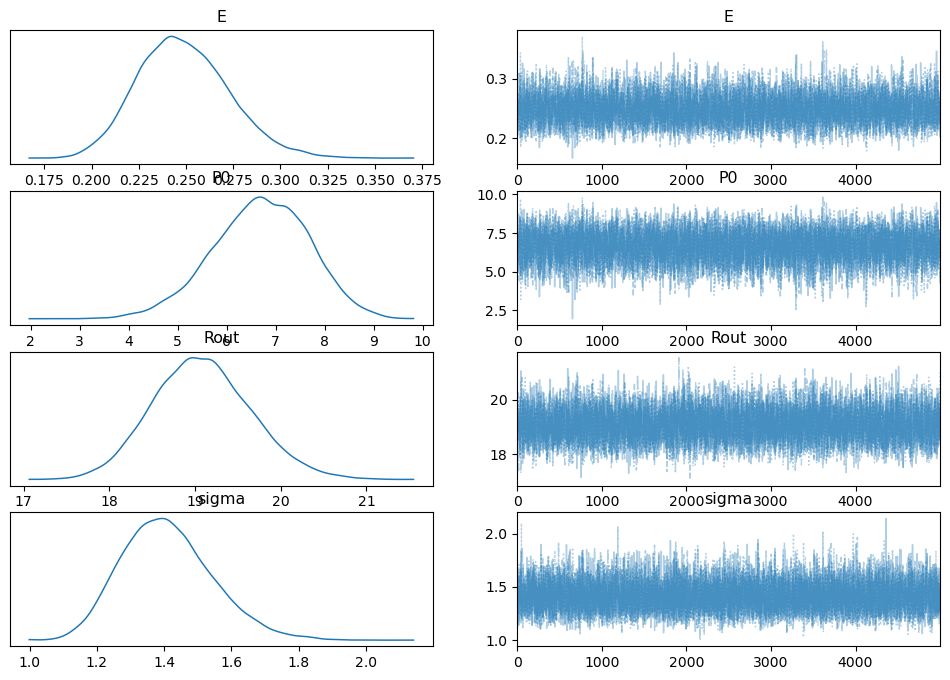

In [22]:
az.plot_trace(idata, combined=True);

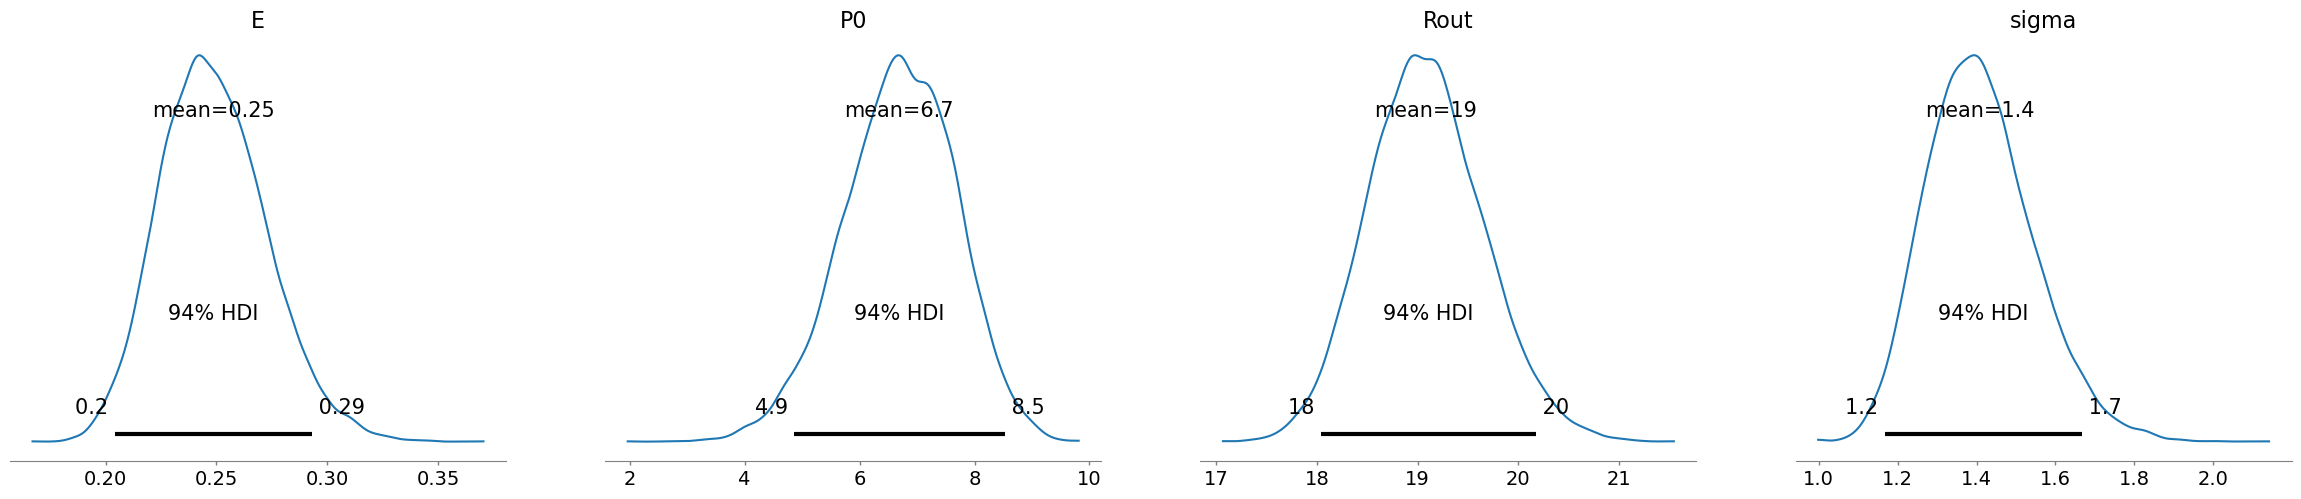

In [23]:
az.plot_posterior(idata, show=True);

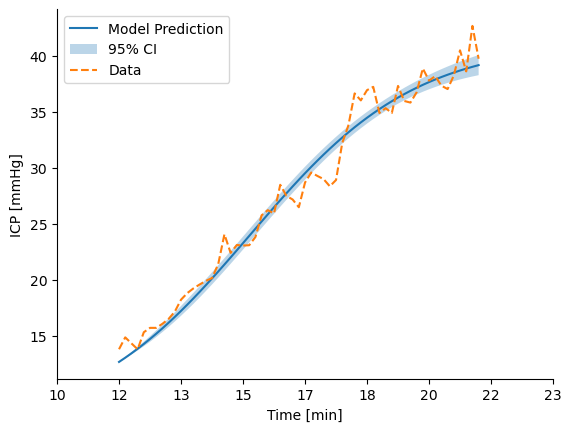

In [24]:
# Plot mean model fit to data with uncertainty
plt.plot(time_points, mean_prediction, label='Model Prediction')
plt.fill_between(time_points, mean_prediction - 2 * std_prediction,
    mean_prediction + 2 * std_prediction, alpha=0.3, label='95% CI')

plt.plot(time_points, icp_trace, label='Data', linestyle='--')
plt.xlabel('Time [min]')
plt.ylabel('ICP [mmHg]')
plt.legend()
plt.xticks(plt.xticks()[0], np.round(plt.xticks()[0]/6).astype(int))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig(f"plots/{arg}.png")
# plt.cla()
plt.show()

